In [1]:
import os
import re
import time
import sys
import numpy as np
import numpy.ma as npma
import math as m
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sys.path.append('C:/Users/ryan744/Desktop/') #Where you put BackTestModule
import BackTestModule
btd = BackTestModule.BacktestData()
op = BackTestModule.Operators()
cp = BackTestModule.CalculatePosition()
from BackTestModule import Backtest

Initializing BacktestData...
C://StockDB/data/
ret 0.01933850315589585
bm_ret 0.019468867
Successfully Initializing BacktestData
Initializing Operator...
Successfuly Initializing Operator


In [2]:
#btd.database['']
import_datas =['close','fore','ret_bwd','bm_ret_bwd','mktc','sector','segment']

for ibd in import_datas:
    print(ibd)
    btd.ImportData(ibd,_encoder='utf-8')
btd.ShowDFList()

close
fore
ret_bwd
bm_ret_bwd
mktc
sector
segment


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (5,41,42,43,44,45,46,47,70,72,73,74,75,76,129,157,179,180,187,188,189,191,192,193,194,195,196,197,209,215,218,227,228,239,251,254,257,260,261,263,265,277,278,323,324,325,326,327,328,339,348,349,351,352,353,354,355,364,368,377,393,401,412,431,434,441,446,452,486,501,512,522,524,548,567,610,611,612,615,616,617,618,625,627,628,629,631,632,633,634,635,636,637,638,639,640,641,642,643,644,663,667,673,679,681,682,696,711,712,713,714,715,716,717,718,727,779,781,785,786,791,792,796,805,809,810,813,814,817,818,821,823,826,827,851,854,863,866,871,877,886,888,894,896,901,902,906,908,912,916,919,920,921,924,930,935,943,952,956,963,964,965,969,975,982,983,986,987,988,989,991,994,997,999,1000,1001,1002,1007,1009,1010,1011,1014,1016,1021,1027,1028,1029,1030,1031,1034,1035,1036,1037,1039,1040,1041,1042,1044,1045,1046,1047,1048,1051,1052,1054,1055,1056,1057,1063,1064,1065,1066,1067,1068,1069,1070,1072

['bm_ret',
 'bm_ret_bwd',
 'close',
 'fore',
 'mktc',
 'ret',
 'ret_bwd',
 'sector',
 'segment']

In [ ]:
import_caches =['close_sma60','mktc_rank']

for ibc in import_caches:
    print(ibc)
    btd.ImportCache(ibc)
btd.ShowDFList()

In [4]:
btd.database['mktc_rank'] = op.Rank(btd.database['mktc'])

In [5]:
btd.database['close_sma60'] = op.ColumnMean(btd.database['close'],60)

In [7]:
btd.database['fore_sum60'] = op.ColumnSum(btd.database['fore'],60)

In [ ]:
#See more function in "operator_example.ipynb"

In [8]:
export_datas = ['fore_sum60','mktc_rank','close_sma60']
for exd in export_datas:
    print(exd)
    btd.ExportData(exd)

fore_sum60
mktc_rank
close_sma60


In [ ]:
'''
研究歷程:

'''

1.0
Winrate: 47.56%
ABS_Winrate: 52.71%
Turnover Rate: 18.6%
0.5760915367850616 252.0 2212
{'Ret': '-6.09%', 'Std': '20.15%', 'Sharpe': '-30.22%', 'DD': '-54.56%', 'RtoDD': '-11.16%'}
0.5760915367850625 252.0 2212
2.076465198377302 252.0 2212


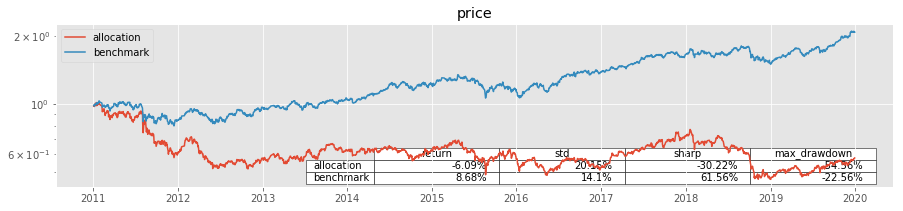

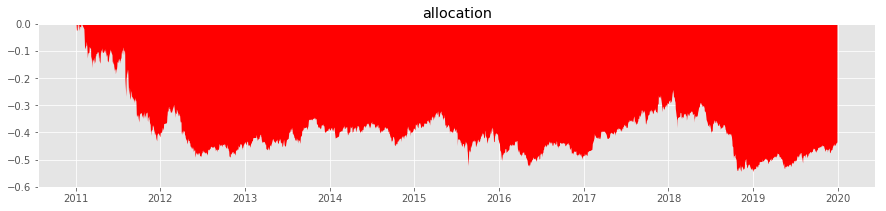

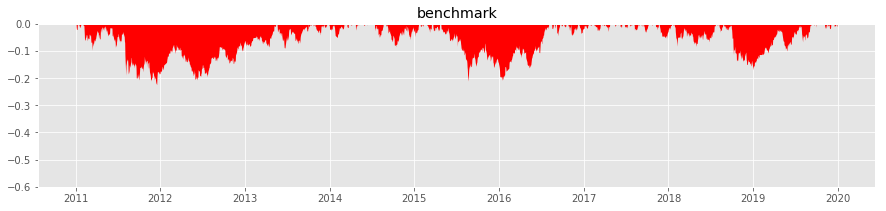

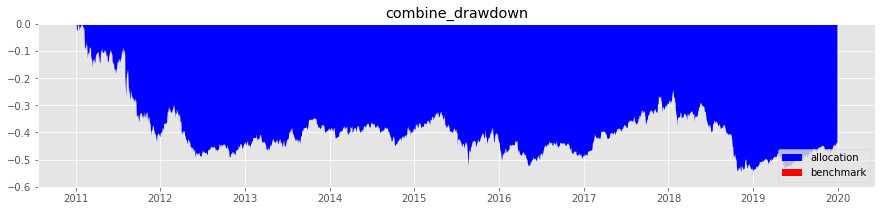

(25.35s)



In [10]:
#Loop test
single_strs = {}

for i in range(1):
    start = time.time()
    var = 1+0.05*i
    print(var)
    uni0 = op.BinaryStep(btd.database['mktc_rank'],(50,850))
    condi1 = np.where(btd.database['close']-btd.database['close_sma60']>0,1,0) #股價位於季線以上
    condi2 = np.where(btd.database['fore_sum60']>0,1,0) #外資近一季買超
    
    pos_mcondi = cp.Multiply([uni0,condi1,condi2])
    #pos_mcondi = pos_mcondi.shift(1) 
     # This will help you know how your alpha diminish as time glides on 
    #pos_mcondi = cp.AdjustFreq(pos_mcondi,start=60,new_freq=1) 
     # You can adjust rebalancing frequency by this
    
    pos_str = op.TransNPtoOriDF(pos_mcondi,btd.database['ret']) #Trans your np-like condi toward df-like 
    
    keeping_condi = np.where(btd.database['fore_sum60']>0,1,0)
    pos_str = cp.MinHoldingPeriodConditional(pos_str,10,keeping_condi)
     #Hold the position in next 10 days if "keeping_condi" is satisfied
    
    #pos_mid_str = cp.MinHoldingPeriod(pos_mid_str,10)
     #Hold the position in next 10 days no matter what happen.
    
    pos_str = cp.PickByDF(pos_str,btd.database['mktc_rank'],10,descending=False)
     #Order qualified stocks by DF(descending or ascending), and choose first 10 stocks.
    
    pos_str = cp.Weight(pos_str,weight=1) #weight can be number,df,np
     #Give weight to each stock. e.g. 市值加權法: weight=btd.database['mktc'])
    
    #pos_str = cp.Neutral(pos_str) 
     #Demean your position, so that money put in long/short position is the same.
    #pos_str = cp.SegNeutral(pos_str,btd.database['sector'])
     #Demean your position, so that money put in long/short position in every segment is the same.
     #Be awared! When using "Neutral" function, you should carefully define your universe first, otherwise, you might short sell some can't-short stocks.
    
    pos_str = cp.Scale(pos_str) 
     #Must use! this function scale your sum(abs(position)) to 1 in each period.
    
    #pos_tf = np.where(btd.database['bm_ret_bwd']>-0.01,1,0)
    #pos_str *= pos_tf
     #After scaling, you can't add some time-filter so that your equity portion can be less than 1 in bearish market
    
    pos_str = cp.MaxHoldingCap(pos_str,0.10)
     #Set maximum holding cap of each stock, generally be 10% for Invest Trust.
    pos_str_df = cp.OutputDF(pos_str)
     #Must use! this function make sure your position matrix satisfied the requirement of following processure.
    parameter = {
        'pos':pos_str_df,
        'start_date': dt.datetime(2011,1,1), #Backtest starting date
        'end_date':dt.datetime(2019,12,30), #Backtest ending date
        'extend_date':dt.datetime(2019,12,31), #Backtest ending date + 1 day (for plotting purpose)
        'valid_period':1, # Set starting day to "start_date"+n days. You might you this when your strategy involve some "lookback" indicies, so first n days get NAN, which doesn't make sense to test through.
        'fee_rate':0.0022125, #Transaction cost. In Taiwan, fee_rate = (0.3+0.285*discount rate of broker)/2 
        'period_in_year':252, #How many periods is there in your "ret" data, generally set as 252 for daily data, and 52 for weekly data.
        'alternative':'cash' #What you invest in when Equity position smaller than 1. You can use "TLT","AGG,"Gold",and so on. 
          # When you key "TLT" in this parameter, put "TLT" daily return in btd.database['TLT'] ,so that system can find it.
    }
    bt = Backtest(**parameter)
    bt.ExportPlot()
    #single_strs[lb] = bt.single_str
    end = time.time()
    print('('+'%s'%np.round(end-start,2)+'s)\n')

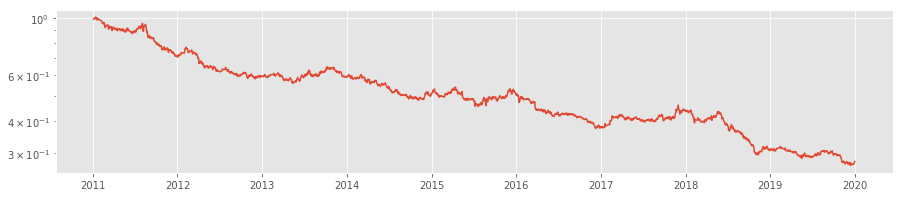

In [11]:
bt.OutplayGraph()
 # Show NAV of strategy/NAV of benchmark

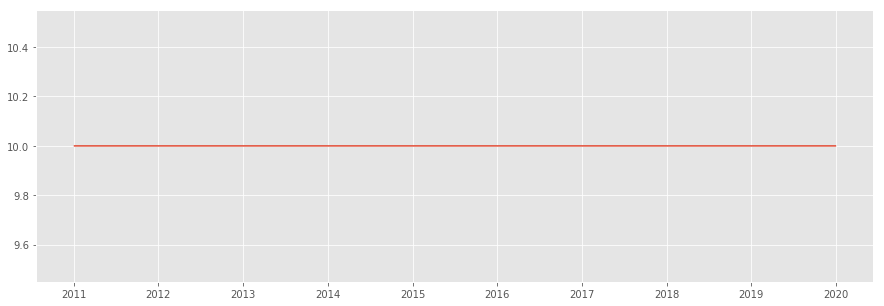

,0
2019-12-03,10
2019-12-04,10
2019-12-05,10
2019-12-06,10
2019-12-09,10
2019-12-10,10
2019-12-11,10
2019-12-12,10
2019-12-13,10
2019-12-16,10


In [12]:
plt.figure(figsize=(15,5))
plt.plot(bt.NumberOfHolding())
plt.show()
 # Show number of stocks you hold during backtesting period
bt.NumberOfHolding().tail(20)
 # Show number of stocks you hold in last 20 days

In [4]:
pos_str_df.to_csv('pro_example.csv')
 #Save it! You can check the correlation between several strategies in future.

In [13]:
#最新部位
newest_num=-1
new = bt.able_position.iloc[newest_num,:]
print(bt.able_position.index[newest_num])
for j in range(len(new)):
    if new.iloc[j] > 0:
        print(bt.firms[j],'weight.','%.2f'%new.iloc[j])

2019-12-30 00:00:00
1476 weight. 0.10
2301 weight. 0.10
2379 weight. 0.10
2409 weight. 0.10
2492 weight. 0.10
2888 weight. 0.10
4958 weight. 0.10
5347 weight. 0.10
6669 weight. 0.10
9904 weight. 0.10


In [14]:
bt.Receipt(start_date=1600,end_date=1750) #Detailed holding with ticker and its return.(You can know which firm is trolling by this)

2017-07-07 00:00:00
1227 -0.0148
2227 -0.0054
2324 0.0172
2344 -0.0082
3034 0.0086
3231 -0.0033
5871 0.0047
6239 0.0
8299 0.0
8464 0.0299
2017-07-10 00:00:00
1227 0.01
1476 0.0027
2227 0.0072
2324 0.0387
3034 0.0085
3231 0.0164
5871 -0.0128
6239 0.0421
8299 0.0508
8464 0.0522
2017-07-11 00:00:00
1227 -0.0174
1476 0.0108
1590 0.0149
2227 0.0
2324 -0.0093
3231 0.0065
5871 0.0095
6239 0.0091
8299 0.0039
8464 0.0152
2017-07-12 00:00:00
1227 0.0063
1476 0.0027
2227 0.0089
2324 -0.0023
3105 0.0268
3231 -0.0128
5871 -0.0047
6239 0.011
8299 -0.0039
8464 0.0176
2017-07-13 00:00:00
1227 0.0101
1476 -0.0027
2227 0.0124
2324 0.0118
3231 -0.0065
3702 0.0024
5871 0.0035
6239 0.005
8299 0.0222
8464 -0.0133
2017-07-14 00:00:00
1476 -0.0133
2227 -0.0017
2324 -0.014
3034 -0.0124
3231 -0.0016
3702 -0.0131
5871 0.0199
6239 -0.0099
8299 0.0486
8464 0.0
2017-07-17 00:00:00
1476 -0.0108
2227 -0.0035
2324 -0.0236
3034 0.0084
3231 -0.0016
3702 0.012
5871 0.0069
6239 0.0
8299 0.0634
8464 0.0135
2017-07-18 00:00

1590 -0.001
2049 0.0433
2324 0.0159
2327 0.0283
2337 -0.0544
2448 -0.0098
2888 0.0031
3105 0.0323
3532 -0.005
5347 0.0345
2017-11-08 00:00:00
1590 -0.0219
2049 -0.0277
2324 -0.0134
2327 -0.0098
2337 -0.0445
2448 -0.0579
2888 -0.0165
3105 -0.0404
3532 -0.006
5347 -0.0083
2017-11-09 00:00:00
1590 -0.0192
2049 0.0111
2324 -0.0317
2327 0.0318
2337 0.0078
2377 -0.009
2888 0.0021
3105 0.0268
3532 0.031
5347 -0.0101
2017-11-10 00:00:00
1590 0.0283
2049 -0.0141
2327 -0.025
2337 -0.0462
2360 -0.0156
2377 -0.0273
2888 0.0031
3105 0.0299
3532 0.068
5347 0.0051
2017-11-13 00:00:00
1590 0.0201
2049 -0.019
2327 -0.002
2337 0.0061
2347 0.0027
2360 -0.0475
2888 -0.001
3105 -0.0254
3532 -0.0182
5347 0.0051
2017-11-14 00:00:00
1590 -0.0155
2049 0.0162
2327 0.0416
2337 0.008
2347 -0.016
2360 0.01
2888 -0.0063
3105 -0.0149
3532 0.0324
5347 -0.0084
2017-11-15 00:00:00
1590 -0.0011
2049 0.008
2327 0.0532
2337 -0.005
2360 0.0362
2377 0.0081
2888 0.0115
3105 0.0453
3532 0.009
5347 0.0
2017-11-16 00:00:00
1590

25850


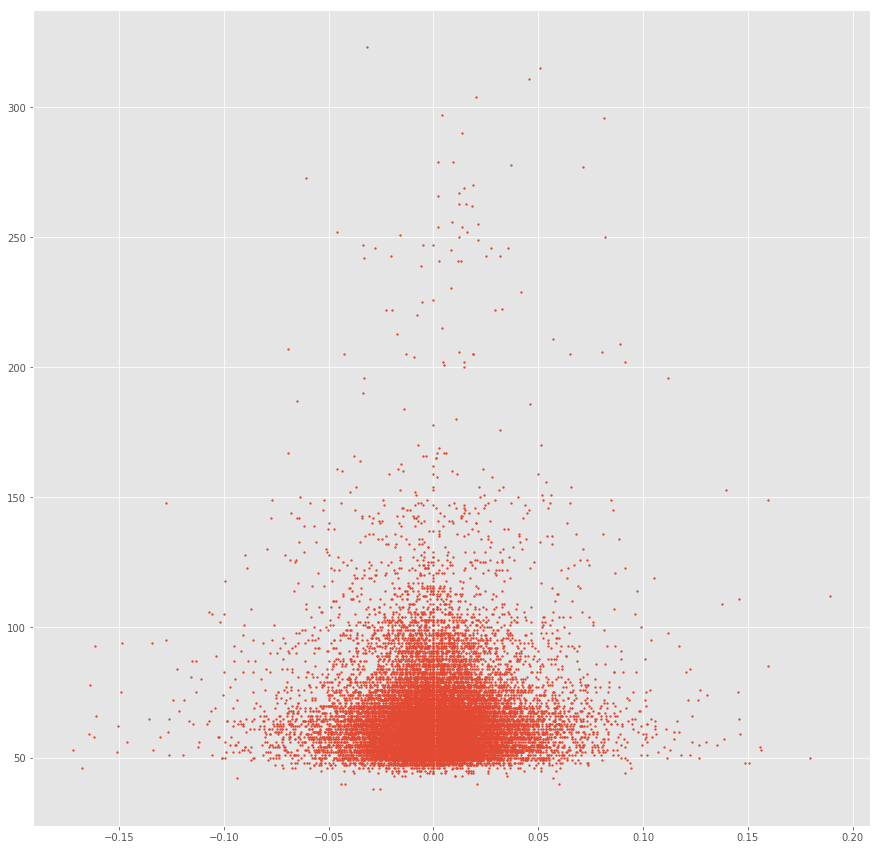

In [15]:
# See the scatter plot, maybe you'll know how to choose a better threshold or get some new idea.
x = (btd.database['mktc_rank']).values
y = btd.database['ret'].values
p = pos_str_df.values

xs = []
ys = []
for i in range(len(p)):
    for j in range(len(p[i])):
        if p[i,j] > 0:
            xs.append(x[i,j])
            ys.append(y[i,j])
plt.figure(figsize=(15,15))
#plt.ylim(-20,150)
plt.scatter(ys,xs,s=3)
print(len(xs))

In [16]:
bt.RollingTest(interval_length=252)
 #See performance of your strategy against benchmark in each period

Period 0
Str:
0.6170511089224012 252.0 252
['-38.29%', '29.51%', '-129.75%', '-43.27%', '-88.5%']
Benchmark:
0.8611169823109525 252.0 252
['-13.89%', '20.48%', '-67.8%', '-22.56%', '-61.56%']
Period 252
Str:
0.9318609043594208 252.0 252
['-6.81%', '19.38%', '-35.15%', '-27.98%', '-24.35%']
Benchmark:
1.1077722544927149 252.0 252
['10.78%', '14.63%', '73.65%', '-14.18%', '75.98%']
Period 504
Str:
1.0947714027603048 252.0 252
['9.48%', '15.92%', '59.55%', '-9.94%', '95.37%']
Benchmark:
1.106631918870269 252.0 252
['10.66%', '11.17%', '95.47%', '-9.12%', '1.17']
Period 756
Str:
1.0161275262549339 252.0 252
['1.61%', '16.83%', '9.58%', '-14.18%', '11.37%']
Benchmark:
1.199223464102556 252.0 252
['19.92%', '12.48%', '1.6', '-8.68%', '2.3']
Period 1008
Str:
0.878306888436301 252.0 252
['-12.17%', '25.29%', '-48.12%', '-29.64%', '-41.05%']
Benchmark:
0.9140362697236245 252.0 252
['-8.6%', '16.44%', '-52.28%', '-21.23%', '-40.49%']
Period 1260
Str:
1.052178277150882 252.0 252
['5.22%', '15.28%

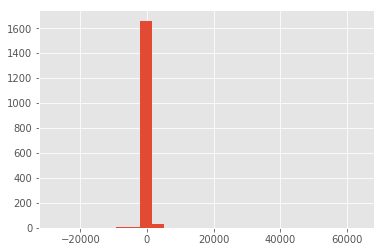

In [19]:
#See the distribution of data, so that you know how to transform it toward a better distribution.
sel_time = dt.datetime(2020,9,25)
cs = btd.database['fore'].loc[sel_time,:]
plt.hist(cs,bins=25)
plt.show()

In [21]:
a0 = btd.database['mktc_rank']
a1 = btd.database['close']
a2 = btd.database['close_sma60']
a3 = btd.database['fore_sum60']

100
         Mean     Std      Pop.        T
Wins   0.0116  0.0141   52704.0      NaN
Loses -0.0134  0.0135   62299.0      NaN
Total -0.0019  0.0186  115003.0 -34.9292
200
         Mean     Std      Pop.       T
Wins   0.0125  0.0152  110867.0     NaN
Loses -0.0138  0.0140  134280.0     NaN
Total -0.0019  0.0196  245147.0 -48.409
300
         Mean     Std      Pop.        T
Wins   0.0128  0.0158  173584.0      NaN
Loses -0.0139  0.0144  212914.0      NaN
Total -0.0019  0.0201  386498.0 -59.7228
400
         Mean     Std      Pop.        T
Wins   0.0132  0.0164  245047.0      NaN
Loses -0.0143  0.0148  299976.0      NaN
Total -0.0019  0.0207  545023.0 -68.2975
500
         Mean     Std      Pop.        T
Wins   0.0136  0.0168  317010.0      NaN
Loses -0.0145  0.0151  389789.0      NaN
Total -0.0019  0.0212  706799.0 -75.7262
600
         Mean     Std      Pop.        T
Wins   0.0138  0.0172  390104.0      NaN
Loses -0.0146  0.0154  482338.0      NaN
Total -0.0019  0.0215  872442.0 -82.6

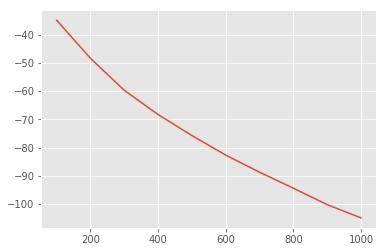

In [27]:
#You can find material quickly by doing so, generally, T-stat > 8 is preferred.
var_list = []
T_stat_list = []
tc = 0.0022125
for i in range(1,11):
    var = 100*i
    print(var)
    x = np.where((a0<=var)&(a1>=10)&(a1<50),btd.database['ret'],np.nan)
    record = []
    positive=[]
    negative=[]
    for i in range(len(x)):
        for j in range(len(x[0])):
            ret = x[i,j]
            if ret == ret:
                record.append(ret)
                if ret>0:
                    positive.append(ret)
                else:
                    negative.append(ret)

    res = np.full((3,4),0.0)
    res[0] = [np.mean(positive)-tc,np.std(positive),len(positive),np.nan]
    res[1] = [np.mean(negative)-tc,np.std(negative),len(negative),np.nan]
    res[2] = [np.mean(record)-tc,np.std(record),len(record),(m.sqrt(len(record))*(np.mean(record)-tc)/(np.std(record)))]
    res = pd.DataFrame(res,index=['Wins','Loses','Total'],columns=['Mean','Std','Pop.','T'])
    print(res.round(4))
    var_list.append(var)
    T_stat_list.append((m.sqrt(len(record))*(np.mean(record)-tc)/(np.std(record))))
plt.plot(var_list,T_stat_list)
plt.show()

# Special Indices